In [1]:
#%%time
#create DASK scheduler and worker remote containers
#this will take at least one minute as there are delays added on purpose to allow containers to spawn
#on successful run you should see scheduler URL printed

#!python3 daskmaster.py

In [2]:
# defined as global
daskschurl = ""

In [3]:
import cdsw
import os
import time

def dask_distributed_launch(nworkers=1,ncpu=2,nmemory=4):
    # modify global copy
    global daskschurl
    
    #check if already running
    if daskschurl!="":
        #print(cdsw.list_workers())
        print(" Dask Scheduler Already Launched " + daskschurl)
        return(daskschurl)
    
    # Launch CDSW workers. These are engines that will run in 
    # the same project, execute a given code or script, and exit.
    # Scheduler engine will keep running in background until session is closed
    dask_scheduler = cdsw.launch_workers(n=1, cpu=2, memory=4, 
                                  kernel="python3",script="daskschedular.py")


    # IP of launched container comes up unknown for a while
    # Wait for a while so IP is available in data structure
    time.sleep(30)

    # Get schedular IP
    schedulerid = dask_scheduler[0]["id"]
    listtemp = cdsw.list_workers()

    for x in listtemp:
      if x["id"] == schedulerid:
        schedulerip = x["ip_address"]


    print(" Scheduler IP: " + schedulerip)

    #Scheduler protocol and port - defaults from Dask
    schproto = "tcp://"
    schport = ":8786"

    schloc = schproto + schedulerip + schport
    print(" Scheduler URL: " + schloc)

    dask_client = []
    # Launch at least one Dask Worker
    for c in range(nworkers):
        dask_client = dask_client + cdsw.launch_workers(n=1, cpu=ncpu, memory=nmemory, 
                                  kernel="python3",script="daskworker.py",
                                      env={"DASKSCHURL": schloc})

        # wait for a while until the container is launched successfully
        time.sleep(10)
    
    #set scheduler URL as environment variable
    #os.putenv("DASKSCHURL", schloc)
    daskschurl = schloc

    #return scheduler URL
    return(schloc)


def dask_stop_workers():
    global daskschurl
    cdsw.stop_workers()
    daskschurl = ""
    

In [4]:
def dask_test():
    from dask.distributed import Client
    client = Client(daskschurl)
    import dask.array as da
    x = da.random.random((40000,40000),chunks=(1000,1000))
    y = da.exp(x).sum()
    print(" Result of DASK distributed array test: " + str(y.compute()) + "\n")


In [29]:
#stop any previous dask distributed containers
dask_stop_workers()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "/usr/local/lib/python3.6/dist-packages/distributed/client.py", line 1296, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "/usr/local/lib/python3.6/dist-packages/distributed/client.py", line 1296, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File

In [6]:
#launch scheduler and worker container(s) - you can specify number of workers as argument
#to relaunch - first call dask_stop_workers() and then call this again
dask_distributed_launch(2,4,8)

 Scheduler IP: 10.10.6.151
 Scheduler URL: tcp://10.10.6.151:8786


'tcp://10.10.6.151:8786'

In [7]:
#check if global variable has the right URL
#we will use this to register a client
print(daskschurl)

tcp://10.10.6.151:8786


In [8]:
import pandas as pd
import cdsw
#any previously stopped pods may show up with status failed
#we are not showing those
workers_list = cdsw.list_workers()
print(" === List of launched running pods === ")
print(" ===      (scheduler + workers)    === ")

#collect relevant fields
workersl = []
for l in workers_list:
    #print(l)
    #print(" id: " + l["id"] + " IP Addr: " + l["ip_address"] + " CPUs: " + str(l["cpu"]) + " Memory: " + str(l["memory"]) \
    #     + " Status: " + l["status"])
    workersl = workersl + [[l["id"],l["ip_address"],l["cpu"],l["memory"],l["status"]]]

workersactive = pd.DataFrame(workersl,columns=["Id","IP Address","CPUs","Memory","Status"])
print(workersactive[workersactive.Status=="running"])

 === List of launched running pods === 
 ===      (scheduler + workers)    === 
                 Id    IP Address  CPUs  Memory   Status
0  c2u86kezuojdhr4i  10.10.25.197     4       8  running
1  6tfbr81w2n6ib5xd    10.10.24.8     4       8  running
2  3jg6twu1vfqkq5sk   10.10.6.151     2       4  running


In [9]:
%%time
#check distributed dask is working
dask_test()

#Register a DASK client and run a test
#from dask.distributed import Client
#client = Client(daskschurl)
#import dask.array as da
#x = da.random.random((40000,40000),chunks=(1000,1000))
#y = da.exp(x).sum()
#print("DASK test result: ") 
#print(y.compute())

 Result of DASK distributed array test: 2749257516.82

CPU times: user 6.34 s, sys: 95.3 ms, total: 6.43 s
Wall time: 9.82 s


In [30]:
%%time
#Read file from S3
#configure access via aws configure in terminal
#need pip3 install awscli for it to work

#Dask dataframe has poor ability to infer column types
#Need to be fixed manually
#options can be modified in ~/.config/dask/distributed.yaml 

#set daskschurl in case running DASK containers manually
daskschurl="tcp://10.10.29.32:8786"

#Register a client to DASK
from dask.distributed import Client
client = Client(daskschurl)

#Read S3 file into distributed DASK dataframe
import dask.dataframe as dd
import s3fs
df = dd.read_csv("s3://harshalpatil-s3/winedatagen.csv", \
                blocksize="25MB",sample=10000000,dtype={'target': 'int64'})

CPU times: user 230 ms, sys: 125 ms, total: 355 ms
Wall time: 3.32 s


In [31]:
#check number of partitions 

#df.known_divisions
#df.set_index("grade")
#df = df.repartition(npartitions=10000)
df.npartitions


79

In [32]:
#DASK also implements lazy computations - so a compute() asks it to return output
df.describe().compute()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,8.000000e+06,8.000000e+06,8.000000e+06,8.000000e+06,8.000000e+06,8.000000e+06,8.000000e+06,8.000000e+06,8.000000e+06,8.000000e+06,8.000000e+06,8.000000e+06,8.000000e+06,8.000000e+06
mean,1.299392e+01,2.332427e+00,2.365318e+00,1.949121e+01,9.967706e+01,2.294691e+00,2.030454e+00,3.615189e-01,1.589443e+00,5.044131e+00,9.583017e-01,2.611218e+00,7.465777e+02,9.374949e-01
std,8.067913e-01,1.112079e+00,2.734620e-01,3.321494e+00,1.420271e+01,6.252325e-01,9.951441e-01,1.239290e-01,5.706906e-01,2.306384e+00,2.277664e-01,7.045503e-01,3.144392e+02,7.713826e-01
min,1.099657e+01,6.969761e-01,1.348081e+00,1.045898e+01,6.939958e+01,9.530976e-01,3.015040e-01,1.247091e-01,3.870241e-01,1.190024e+00,4.705211e-01,1.240964e+00,2.643978e+02,0.000000e+00
25%,1.235836e+01,1.599035e+00,2.211006e+00,1.719324e+01,8.814730e+01,1.747411e+00,1.217931e+00,2.685020e-01,1.245621e+00,3.222983e+00,7.878902e-01,1.958860e+00,5.021916e+02,0.000000e+00
50%,1.304644e+01,1.867782e+00,2.360186e+00,1.947494e+01,9.794045e+01,2.364477e+00,2.146554e+00,3.394371e-01,1.556280e+00,4.694467e+00,9.706491e-01,2.784126e+00,6.734493e+02,1.000000e+00
75%,1.367907e+01,3.107489e+00,2.559905e+00,2.150889e+01,1.073459e+02,2.803440e+00,2.880515e+00,4.415163e-01,1.956620e+00,6.222763e+00,1.120313e+00,3.177463e+00,9.878831e+02,2.000000e+00
max,1.486411e+01,5.844729e+00,3.241477e+00,3.013543e+01,1.625593e+02,3.913124e+00,5.117904e+00,6.663920e-01,3.603631e+00,1.309393e+01,1.719769e+00,4.033403e+00,1.693024e+03,2.000000e+00


In [33]:
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,12.453044,3.057563,2.637468,26.982976,96.894834,1.894684,0.576775,0.631005,1.141916,7.503330,0.667473,1.733635,884.000317,2
1,13.173402,5.185555,2.319365,22.021634,93.348647,1.737400,0.642461,0.609534,1.542117,7.892997,0.601167,1.479785,723.914462,2
2,12.931853,3.795806,2.649335,18.583969,102.092081,2.414713,2.411137,0.250561,1.990316,4.532924,1.030724,3.515004,770.452675,0
3,12.174664,1.449220,2.529297,19.002528,103.411055,1.880124,1.742236,0.448931,1.036029,2.925974,1.453105,2.222418,354.950337,1
4,14.380216,3.604127,2.280906,16.007552,101.989299,3.253761,3.180700,0.274111,2.188761,4.872111,1.037183,3.437077,1061.719433,0


In [18]:
#df["target"]

Dask Series Structure:
npartitions=79
    int64
      ...
    ...  
      ...
      ...
Name: target, dtype: int64
Dask Name: getitem, 316 tasks

In [34]:
#Use the wine dataset

#Target
dt=df["target"]

#Features
df1=df.drop(columns=["target"])

#print a few lines
print("\n Dataframe: ")
print(df1.head())

#print target classes example
print("\n Target: ")
print(dt.head())      



 Dataframe: 
     alcohol  malic_acid       ash  alcalinity_of_ash   magnesium  \
0  12.453044    3.057563  2.637468          26.982976   96.894834   
1  13.173402    5.185555  2.319365          22.021634   93.348647   
2  12.931853    3.795806  2.649335          18.583969  102.092081   
3  12.174664    1.449220  2.529297          19.002528  103.411055   
4  14.380216    3.604127  2.280906          16.007552  101.989299   

   total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
0       1.894684    0.576775              0.631005         1.141916   
1       1.737400    0.642461              0.609534         1.542117   
2       2.414713    2.411137              0.250561         1.990316   
3       1.880124    1.742236              0.448931         1.036029   
4       3.253761    3.180700              0.274111         2.188761   

   color_intensity       hue  od280/od315_of_diluted_wines      proline  
0         7.503330  0.667473                      1.733635   884.00031

In [35]:
%%time
# train and test split
from dask_ml.model_selection import train_test_split
train, test, train_labels, test_labels = train_test_split(df1,dt,random_state=123)      
      
#xgboost
from dask_ml.xgboost import XGBClassifier
est = XGBClassifier()      
      
#fit model      
model = est.fit(train, train_labels)


CancelledError: 

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "/usr/local/lib/python3.6/dist-packages/distributed/client.py", line 1296, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "/usr/local/lib/python3.6/dist-packages/distributed/client.py", line 1025, in _reconnect
    await self._close()
  File "/usr/local/lib/python3.6/dist-packages/distributed/client.py", line 1296, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError


In [28]:
#which features contribute most
#get feature importance in a pandas dataframe
import pandas as pd
featureimp = pd.DataFrame(model.feature_importances_)
featureimp.columns = ['classifier_feature_importance']
featureimp["variable"] = df1.columns
print("\n\n === Xgboost Classifier Feature Importance: === ")
print(featureimp.sort_values(by="classifier_feature_importance", ascending=False))
#featureimp.to_csv()


#predictions
ypred = model.predict(test)

#sample some predictions
print("\n Sample initial five predictions: ")      
print(ypred[[0,1,2,3,4]].compute())
      
#check accuracy on test set      
from dask_ml import metrics
print("\n\n Model Accuracy: ")      
print(metrics.accuracy_score(test_labels,model.predict(test)))
      
print("\n === End Dask Xgboost === \n")




 === Xgboost Classifier Feature Importance: === 
    classifier_feature_importance                      variable
9                        0.256564               color_intensity
12                       0.239798                       proline
6                        0.233610                    flavanoids
0                        0.073820                       alcohol
1                        0.073582                    malic_acid
4                        0.035498                     magnesium
10                       0.029172                           hue
2                        0.018681                           ash
5                        0.018486                 total_phenols
11                       0.012576  od280/od315_of_diluted_wines
3                        0.008092             alcalinity_of_ash
7                        0.000121          nonflavanoid_phenols
8                        0.000000               proanthocyanins

 Sample initial five predictions: 
[1 0 1 1 2]


 Mo

<Container object of 13 artists>

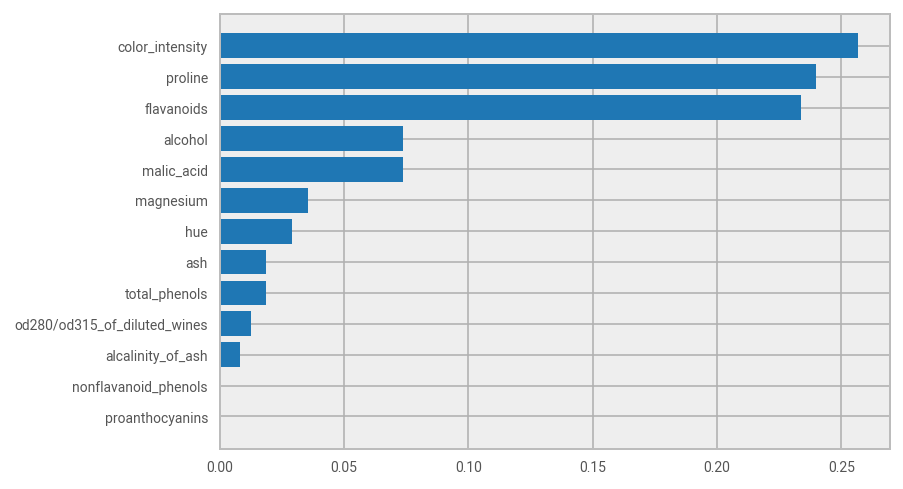

In [27]:
#Model Accuracy is very high simply because we generated the data synthetically
#In real life it will be lower.
#Lets chart the feature importance in a graph - as identified by Xgboost

featureimp = featureimp.sort_values(by="classifier_feature_importance", ascending=True)

from matplotlib import pyplot as plt
plt.barh(range(13),featureimp["classifier_feature_importance"],tick_label=featureimp["variable"])


In [ ]:
#######################
# End 
#######################